# Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import seaborn as sns
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/black-friday-sales-prediction/sample_submission_V9Inaty.csv
/kaggle/input/black-friday-sales-prediction/train_oSwQCTC (1)/train.csv
/kaggle/input/black-friday-sales-prediction/test_HujdGe7 (1)/test.csv


# Import Train & Test Data

In [2]:
BFData=pd.read_csv("../input/black-friday-sales-prediction/train_oSwQCTC (1)/train.csv")
BFData_test=pd.read_csv("../input/black-friday-sales-prediction/test_HujdGe7 (1)/test.csv")
BFData.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


# Descriptive Analysis

In [3]:
BFData.info()
BFData_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB
<class 'pandas

Train data has 12 columns whereas test data has 11 columns as latter does not have Purchase column which needs to be predicted. 

Both of datasets have some null values in columns: Product_Category_2 & Product_Category_3. We will do detail analysis of null values in further steps.

So in next steps, we will join these two datasets to make it suitable for modeling.

In [4]:
# I wanted to check if there is any different category in test data, 
# as columns names are same so i have used For loop on one dataset
for col in BFData.columns:
    if is_string_dtype(BFData[col]):
        print("Unique Values in {} column of BFData is {}".format(col, BFData[col].unique()))
        print("Unique Values in {} column of BFData_test is {}".format(col, BFData_test[col].unique()))

Unique Values in Product_ID column of BFData is ['P00069042' 'P00248942' 'P00087842' ... 'P00370293' 'P00371644'
 'P00370853']
Unique Values in Product_ID column of BFData_test is ['P00128942' 'P00113442' 'P00288442' ... 'P00270742' 'P00253842'
 'P00325442']
Unique Values in Gender column of BFData is ['F' 'M']
Unique Values in Gender column of BFData_test is ['M' 'F']
Unique Values in Age column of BFData is ['0-17' '55+' '26-35' '46-50' '51-55' '36-45' '18-25']
Unique Values in Age column of BFData_test is ['46-50' '26-35' '36-45' '18-25' '51-55' '55+' '0-17']
Unique Values in City_Category column of BFData is ['A' 'C' 'B']
Unique Values in City_Category column of BFData_test is ['B' 'C' 'A']
Unique Values in Stay_In_Current_City_Years column of BFData is ['2' '4+' '3' '1' '0']
Unique Values in Stay_In_Current_City_Years column of BFData_test is ['2' '0' '4+' '1' '3']


clearly, none of the columns in test dataset have any different category than train dataset.

In [5]:
# Combine Both Train and Test Dataset. I have used a new column flag 
# to distinguish Test and Train dataset 

BFData_test['Purchase']=np.nan
BFData_test['flag']='Test'
BFData['flag']='Train'
BF_all_data=pd.concat([BFData,BFData_test])
print(BFData.shape)
print(BFData_test.shape)
print(BF_all_data.shape)

(550068, 13)
(233599, 13)
(783667, 13)


In [6]:
percent_null_values=round((BF_all_data.isnull().sum()/BF_all_data.isnull().count()*100),2).sort_values(ascending=False)
percent_null_values

Product_Category_3            69.65
Product_Category_2            31.39
Purchase                      29.81
User_ID                        0.00
Product_ID                     0.00
Gender                         0.00
Age                            0.00
Occupation                     0.00
City_Category                  0.00
Stay_In_Current_City_Years     0.00
Marital_Status                 0.00
Product_Category_1             0.00
flag                           0.00
dtype: float64

Product_Category_3 has 70% of null values and Product_Category_2 has 31%. Purchase column also has ~30% null values, this is due to absense of Purchase column in test dataset.

Product_Category_3 with these many null values is not worth to fix, so i will delete this column from both datasets and have fixed 30% null values of Product_Category_2 by mode (most frequent) of this column. Mode is the most appropriate method in this case as the column being fixed has categorical values.

In [7]:
#Drop Product_Category_3 column
BF_all_data.drop('Product_Category_3',axis=1,inplace=True)

In [8]:
# fill null values of Product_Category_2 column with mode of this column.
BF_all_data['Product_Category_2'].fillna(BF_all_data['Product_Category_2'].mode()[0],inplace=True)

# Exploratory Data Analysis (EDA)

In [9]:
#Seperate Training Data from cleaned for EDA

BFData_train=BF_all_data[BF_all_data['flag']=='Train']
BFData_train.shape

(550068, 12)

## Univariate Data Analysis
for all columns, let's generate count plot

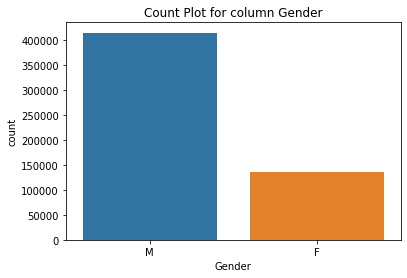

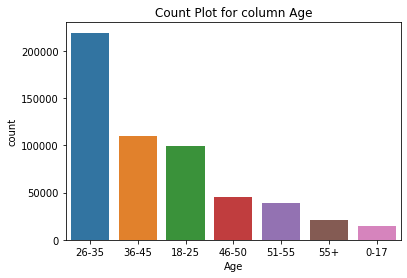

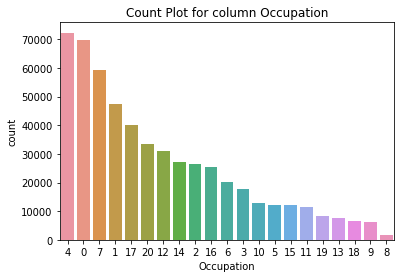

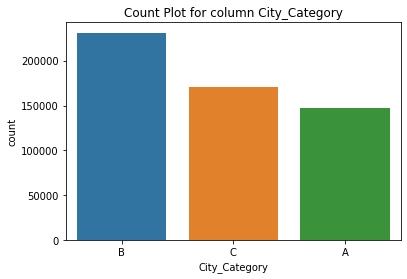

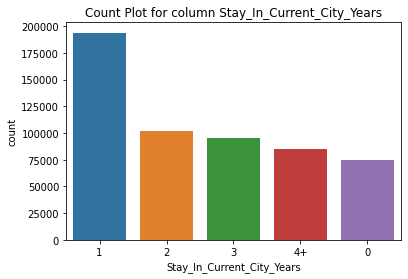

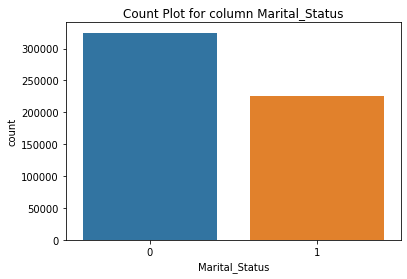

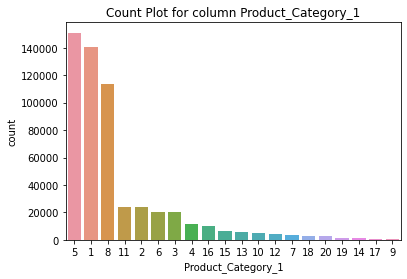

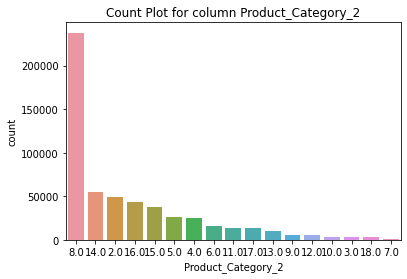

In [10]:
for col in BFData_train.columns:
    if (col not in ('Product_ID', 'User_ID', 'flag','Purchase')):
        sns.countplot(x=col, data=BFData_train, order=BFData_train[col].value_counts().index)
        plt.title("Count Plot for column {}".format(col))
        plt.show()

About dataset, We can observe from above that
* There are more males than females
* Mostly people are in age group 26-35
* There are more people who has an occupation 4 & 0
* Mostly people stay in city B. 
* People generally stay in current city for 1 year
* Maximum people are unmarried
* Most of the products that were shopped belong to category1 5,1,8
* most of the products have 8 has category 2

# Bi-Variate Analysis

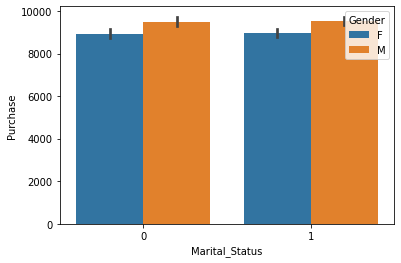

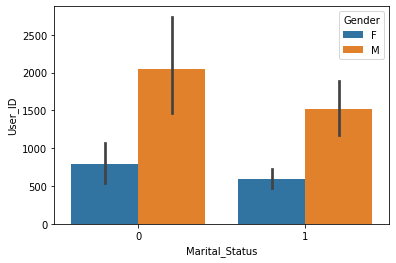

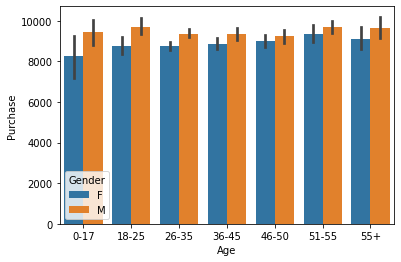

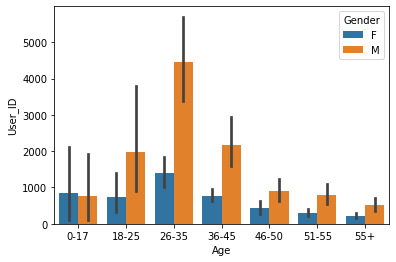

In [11]:
col=['Gender','Marital_Status','Age', 'Occupation']
BFTData_agg=BFData_train.groupby(by=col).agg({'Purchase':'mean', 'User_ID':'count'}).reset_index()
for x_axis in ['Marital_Status','Age']:
    for y_axis in ['Purchase','User_ID']:
        sns.barplot(data=BFTData_agg, x=x_axis,y=y_axis, hue='Gender')
        plt.show()

We can conclude from first two graphs that - Although there are more unmarried people and more males in the city but the amount spent by these two groups are same. It seems like married people and females buy high priced or lower discounted products than unmarried and males.

From third and Forth graphs, there are more males than females in all age groups and more people in dataset belong to 26-35 age group, but amount spent by different age groups are same with same reasoning as above.

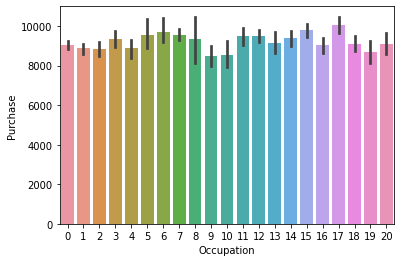

In [12]:
# Lets plot & see if there is same trend for Purchase amount across different Occupations too.
sns.barplot(data=BFTData_agg, x='Occupation', y='Purchase')
plt.show()

In [13]:
"""#Bi-Variate Analysis
plt.figure(figsize=(14,14))
sns.pairplot(BFData_train)
plt.show()"""

'#Bi-Variate Analysis\nplt.figure(figsize=(14,14))\nsns.pairplot(BFData_train)\nplt.show()'

In [14]:
# Corelation
"""plt.figure(figsize=(10,10))
sns.heatmap(BFData.corr(), annot=True)
plt.show()"""

'plt.figure(figsize=(10,10))\nsns.heatmap(BFData.corr(), annot=True)\nplt.show()'

## Top 10 products

In [15]:
# Top 10 Products that were most bought.
bf_prod_agg= BFData_train.groupby(by='Product_ID').agg({'User_ID':'count','Purchase': 'mean'}).reset_index().rename(columns={'User_ID': 'Count of User_ID','Purchase': 'Avg. Purchase'})
print("----------Top 10 Products that were most bought-----------\n")
print(bf_prod_agg.sort_values(by='Count of User_ID', ascending=False).head(10),"\n")
print("----------Top 10 Products that had highest Avg. purchase price-----------\n")
print(bf_prod_agg.sort_values(by='Avg. Purchase', ascending=False).head(10))

----------Top 10 Products that were most bought-----------

     Product_ID  Count of User_ID  Avg. Purchase
2536  P00265242              1880    7534.848404
249   P00025442              1615   17334.468111
1016  P00110742              1612   16577.114764
1030  P00112142              1562   15503.204866
565   P00057642              1470   15716.176871
1745  P00184942              1440   16899.227083
458   P00046742              1438   14709.931850
569   P00058042              1422    8615.073136
1355  P00145042              1406   14517.312945
582   P00059442              1406   17310.343528 

----------Top 10 Products that had highest Avg. purchase price-----------

     Product_ID  Count of User_ID  Avg. Purchase
836   P00086242               273   21256.505495
827   P00085342               552   20980.268116
1902  P00200642               269   20468.773234
1070  P00116142               642   20463.791277
1102  P00119342               308   20448.756494
1085  P00117642               

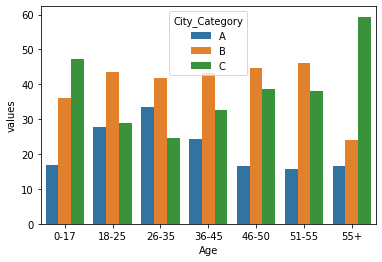

In [16]:
#Age Group distribution across Different Cities (in %)
bf_age_dist_citi=BFData_train.groupby(['Age','City_Category']).agg({'User_ID':'count'}).unstack()
bf_age_dist_citi.columns=bf_age_dist_citi.columns.droplevel()

for i in range(len(bf_age_dist_citi)):
    age_sum=bf_age_dist_citi.iloc[i,:].sum()
    for j in range(bf_age_dist_citi.shape[1]):
        bf_age_dist_citi.iloc[i,j]=round(bf_age_dist_citi.iloc[i,j]/age_sum*100,2)

bf_age_dist_citi=bf_age_dist_citi.stack()
bf_age_dist_citi=bf_age_dist_citi.to_frame().reset_index(level='City_Category').rename(columns={0:'values'})

sns.barplot(data=bf_age_dist_citi, x=bf_age_dist_citi.index,y="values", hue="City_Category")
plt.show()

As we saw above, that most of the people in dataset are of age group 26-35 & mostly live in B city. From above graph, we see it does not follow obvious distribution across different age groups.

Age group 0-17 and 55+ mainly live in city C where as rest other age group mainly live in city B as we see B city has majority of population. It seems like City C is tier 3 city where younger people live and they go to Tier 1 or 2 city and come back once they turn 55.

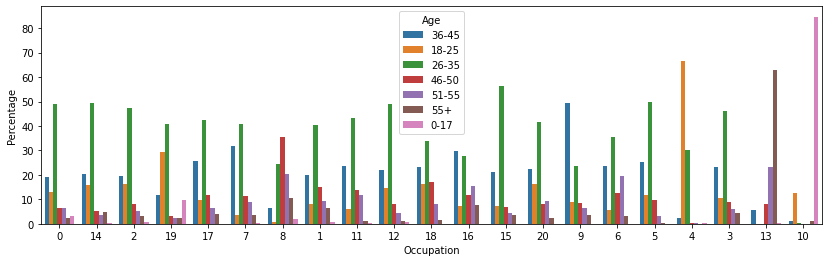

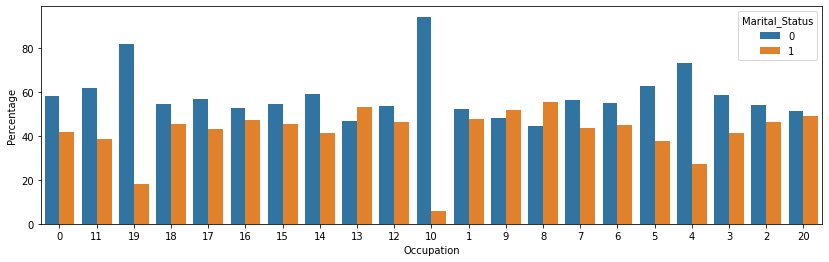

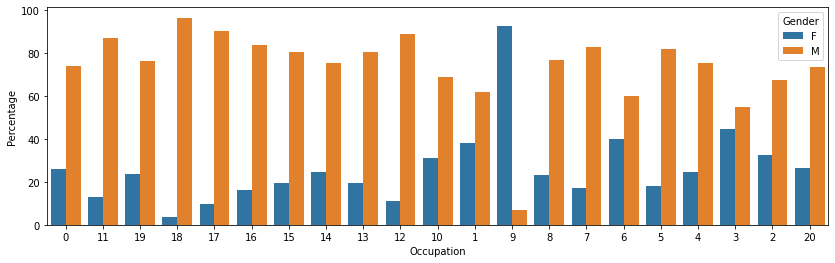

In [17]:
# Top Professions distribution in age Group.
for col in ['Age','Marital_Status','Gender']:
    plt.figure(figsize=(14,4))
    bf_by_prof=BFData_train.groupby(['Occupation',col]).agg({'User_ID':'count'})
    df3=bf_by_prof.groupby(by="Occupation").apply(lambda x:100 * x / float(x.sum())).reset_index().rename(columns={'User_ID':'Percentage'})
    sns.barplot(data=df3, x='Occupation',y='Percentage', hue=col, order=df3['Occupation'].value_counts().index,
           hue_order=df3[col].value_counts().index)
    plt.show()

**For Graph 1 -** 
Across almost all occupation, we see more distribution of 26-35 same as higher distribution of this group in the entire dataset. However there are 
a few exceptions, 
Occupation 8 has more middle age people 46-50, 
Occupation 9 has more 36-45 age group people, 
Occupation 4 has mainly from yonger age 18-25, 
Occupation 13 & 10 oldest and youngest crowd respectively i.e. 55+ and 0-17


**For Graph 2 -** generally speaking, graph follow same distribution having more unmarried people than married people across almost all occupation except few exceptions. Occupation 13, 9, 8 have more married people than unmarried people. Occupation 10, although has more unmarried people but there are a very few married people

**For Graph 3:** It's very intresting to see that only occupation 9 has higher females than males. May be 9 profession is Air Hostess or teacher, from graphs above profession 9 has the lowest avg purchase price, so may be it's low paying occupation? Whereas profession 18 has a lot more males and very few females.

# Data Pre-Processing

We will pre-process the data before feeding the dataset to models. As part if pre-processing, will make all columns as Integer, perform data encoding.

In [18]:
# User_ID & Product_ID columns conversion to integer columns
BF_all_data['User_ID']=BF_all_data['User_ID']-100000
BF_all_data['Product_ID']=BF_all_data['Product_ID'].str.replace('P00','')
BF_all_data['Product_ID']=pd.to_numeric(BF_all_data['Product_ID'])

In [19]:
BF_all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 783667 entries, 0 to 233598
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     783667 non-null  int64  
 1   Product_ID                  783667 non-null  int64  
 2   Gender                      783667 non-null  object 
 3   Age                         783667 non-null  object 
 4   Occupation                  783667 non-null  int64  
 5   City_Category               783667 non-null  object 
 6   Stay_In_Current_City_Years  783667 non-null  object 
 7   Marital_Status              783667 non-null  int64  
 8   Product_Category_1          783667 non-null  int64  
 9   Product_Category_2          783667 non-null  float64
 10  Purchase                    550068 non-null  float64
 11  flag                        783667 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 77.7+ MB


In [20]:
### Data Encoding  - Age, Gender, City Category are columns of type 'Object'. Either we
# can do Label Encoding or Get dummies. With Label Encoder, models may confuse them 
# being columns with orders. So we will perform conversion with Get dummies.

BF_all_data=pd.get_dummies(BF_all_data, columns=['Age','Gender','City_Category'], drop_first=True)
BF_all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 783667 entries, 0 to 233598
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     783667 non-null  int64  
 1   Product_ID                  783667 non-null  int64  
 2   Occupation                  783667 non-null  int64  
 3   Stay_In_Current_City_Years  783667 non-null  object 
 4   Marital_Status              783667 non-null  int64  
 5   Product_Category_1          783667 non-null  int64  
 6   Product_Category_2          783667 non-null  float64
 7   Purchase                    550068 non-null  float64
 8   flag                        783667 non-null  object 
 9   Age_18-25                   783667 non-null  uint8  
 10  Age_26-35                   783667 non-null  uint8  
 11  Age_36-45                   783667 non-null  uint8  
 12  Age_46-50                   783667 non-null  uint8  
 13  Age_51-55     

In [21]:
# column Stay_In_Current_City_Years is 'Object' type column due to '+' sign so will remove that
BF_all_data['Stay_In_Current_City_Years']=BF_all_data['Stay_In_Current_City_Years'].str.strip('+').astype('int64')

In [22]:
# Will convert Product_Category_2 column
BF_all_data['Product_Category_2']=BF_all_data['Product_Category_2'].astype('int64')

In [23]:
#Splitting the data back into test and train set. 

BFData=BF_all_data[BF_all_data['flag']=='Train']
BFData.drop('flag', axis=1, inplace=True)
BFData_test=BF_all_data[BF_all_data['flag']=='Test']
BFData_test.drop(['Purchase','flag'],axis=1,inplace=True)
del BF_all_data

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Modeling

In [35]:
#Import Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#Splitting the dataset into X & Y
X=BFData.drop('Purchase',axis=1)
y=BFData.Purchase

#train test data split
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=101)

# Linear Regression

In [36]:
# Run Linear Regression Model
lm=LinearRegression()
lm.fit(X_train, y_train)
w=lm.coef_
b=lm.intercept_
print(w)
print(b)

[ 1.28126993e-02 -3.76275247e-03  6.82571889e+00  1.26910270e+01
 -4.66356017e+01 -4.14448378e+02 -4.60423256e+01  3.65653070e+02
  5.72189989e+02  7.00282519e+02  6.80198733e+02  1.01488500e+03
  7.85832714e+02  5.34921245e+02  1.67966064e+02  7.24724169e+02]
-339.06908025164194


In [25]:
#predicting test data
predictions=lm.predict(X_test)

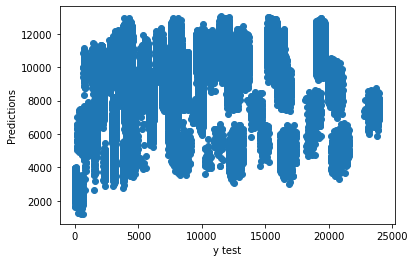

In [26]:
#plot the result

plt.scatter(y_test, predictions)
plt.xlabel('y test')
plt.ylabel('Predictions')
plt.show()

In [27]:
# LR score
from sklearn import metrics

print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R2 Score:',metrics.r2_score(y_test,predictions)*100)

RMSE: 4681.717535945825
R2 Score: 13.109096448684898


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


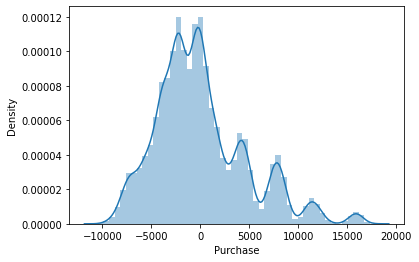

In [28]:
sns.distplot((y_test-predictions),bins=50);
plt.show()

RMSE & R2 score with Linear Regression are very less. Also in the above graph actual & predicted values are not normally distributed. I tried Lasso & Ridge Regression too which did not give much better results. none of the Linear model generated good results, so next will try non-linear models.

## Decision Tree

In [29]:
from sklearn.tree import DecisionTreeRegressor
regressor=DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
dt_y_predict=regressor.predict(X_test)
print("Mean Squared Error",np.sqrt(metrics.mean_squared_error(y_test, dt_y_predict)))
print("R2 Score:",round(metrics.r2_score(y_test,dt_y_predict)*100,2))

Mean Squared Error 3775.903972355713
R2 Score: 43.48


Decision tree with default parameters give better results than Linear regression model with RMSE as 3775 & R2 score as 43.5%

## Random Forest Regression

In [30]:
from sklearn.ensemble import RandomForestRegressor

rfregressor=RandomForestRegressor(random_state=0)
rfregressor.fit(X_train, y_train)
rf_y_predict=rfregressor.predict(X_test)
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, rf_y_predict)))
print("r2 Score:",round(metrics.r2_score(y_test,rf_y_predict)*100,2))

RMSE: 2755.16459090818
r2 Score: 69.91


Random Forest with default parameters give better results than Decision tree with RMSE as 2755 & R2 score ~70%

## XGBoost Regression

In [31]:
from xgboost.sklearn import XGBRegressor

xgb_reg=XGBRegressor(n_estimators=480, learning_rate=0.2, max_depth=8)
xgb_reg.fit(X_train,y_train)
xgb_y_pred=xgb_reg.predict(X_test)
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, xgb_y_pred)))
print("R2 Score:",round(metrics.r2_score(y_test,xgb_y_pred)*100,2))


RMSE: 2512.8566624068903
R2 Score: 74.97


XGBoost regression gave best results out of all non-linear regression models on default parameters, so we tuned some hyperparameters to check if any performance can be improved. with n_estimators as 480, learning rate as .2 and 8 as max depth model predicted with RMSE as 2513 and r2 score as 75%. we tried different parameters but this was best combination, on other parameters it was improving but not worth at the cost of performance.

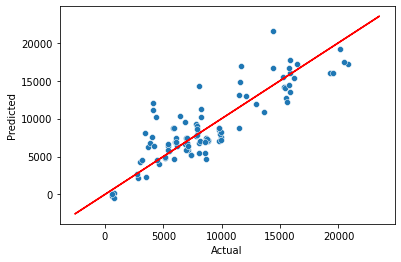

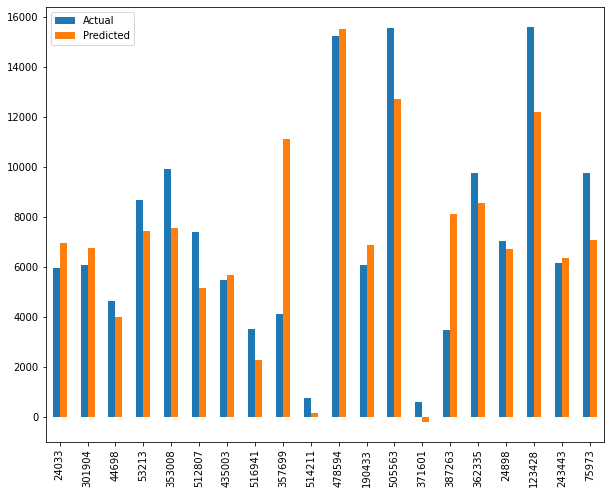

In [32]:
#let's visualize the predicted results.

final_pred=pd.DataFrame({'Actual':y_test,'Predicted':xgb_y_pred})
sns.scatterplot(data=final_pred.head(100), x='Actual',y='Predicted')
plt.plot(xgb_y_pred,xgb_y_pred,'r')
plt.show()
final_pred.head(20).plot(kind='bar',figsize=(10,8))
plt.show()

In [33]:
#Feature Importance

fi=pd.DataFrame(xgb_reg.feature_importances_,index=X.columns, columns=['score'])
fi.sort_values(by='score', ascending=False)

,score
Product_Category_1,0.777040
Product_ID,0.028980
City_Category_C,0.026230
Product_Category_2,0.021748
User_ID,0.013662
Age_55+,0.013595
Age_18-25,0.012711
Gender_M,0.012697
Marital_Status,0.012448
Occupation,0.012071


the most important feature is Product_Category_1

# Predict test data for submission

In [34]:
BFData_test['Purchase']=xgb_reg.predict(BFData_test)
BFData_test[['User_ID','Product_ID','Purchase']]
BFData_test.to_csv('Sample_Submission_V9Inaty.csv')